In [2]:
from glob import glob
import shelve
from datetime import datetime
from collections import namedtuple
from pickle import dump, load

import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoModel, AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer, EarlyStoppingCallback, BatchEncoding
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
import optuna 

from arabert.preprocess import ArabertPreprocessor

# Parameters

In [3]:
# Config
device = torch.device("cuda")

# Data params
validation_size = 4096

# Model params
model_name = "aubmindlab/bert-base-arabertv2"
model = AutoModel.from_pretrained(model_name)
for param in model.parameters():
    param.requires_grad = False
    
# Preprocessing params
sequence_length = 128
arabert_prep = ArabertPreprocessor(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Etc
model_string = f"./models/{str(datetime.today().date())}-train"
dataset_string = "{}_dataset-seqlen" + str(sequence_length)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2021-09-30 02:26:28,388 - farasapy_logger - WARNING]: Be careful with large lines as they may break on intera

# Functions

In [4]:
def get_SMADC_folder_data():
    """Returns a dataframe with Text and Region columns. Requires tree like this data/SMADC/*.txt"""
    files = glob("data/SMADC/*.txt")
    dataframes = []

    for file in files:
        region = file[-7:-4]
        temp_df = pd.read_csv(file, encoding="utf8", delimiter="\n", names=["Text"])
        temp_df["Region"] = region
        dataframes.append(temp_df)
        
    return pd.concat(dataframes)


def get_music_df():
    files = ["GLF","LEV","NOR","IRQ"]
    dataframes = []
    
    for file in files:
        temp_df = pd.read_csv(f'../extra_data/d7_data/{file}.txt', encoding="utf8", delimiter="\n", names=["Text"])
        temp_df["Region"] = file
        dataframes.append(temp_df)
    
    return pd.concat(dataframes)


def tokenize(batch):
    """
    Tokenizes a list of strings
    """
    return tokenizer.batch_encode_plus(
        batch,
        add_special_tokens=True,
        padding="max_length",
        max_length=sequence_length,
        truncation=True,
        return_tensors="pt",
        return_attention_mask=True,
        return_token_type_ids=False,
    )


def batch_tokenize_iter(data, batch_size):
    len_data = len(data)
    batch_num = len_data // batch_size
    batch_rest = len_data / batch_size - batch_num
    
    for i in range(batch_size):
        yield tokenize(data[i * batch_num:(i+1) * batch_num].to_list())
        
    if batch_rest:
        yield tokenize(data[batch_num:].to_list())


def batch_tokenize(data, batch_size):
    bt = batch_tokenize_iter(data, batch_size)
    for i, tokenization in enumerate(bt):
        if not i:
            encoding = tokenization
            continue
        encoding["input_ids"] = torch.cat([encoding["input_ids"], tokenization["input_ids"]])
        encoding["attention_mask"] = torch.cat([encoding["attention_mask"], tokenization["attention_mask"]])
    return encoding


def preprocess_sample(sample):
    """Sample list of strings"""
    return tokenize(list(arabert_prep.preprocess(text) for text in sample))


def save_preprocessed_data(dataset, dataset_name):
    with open(f"preprocessed_data/{dataset_name}.pkl", "wb") as file:
        dump(dataset, file)
        
def load_preprocessed_data(dataset_name):
    with open(f"preprocessed_data/{dataset_name}.pkl", "rb") as file:
        temp = load(file)
    return temp


def compute_metrics(p): 
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    macro_precision = precision_score(p.label_ids,preds,average='macro')
    macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }


def model_init(model_name, num_labels, label2id, id2label):
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=num_labels, label2id=label2id, id2label=id2label)

In [5]:
%%time
# Dataset class
class Dialect_dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        super(Dialect_dataset).__init__()
        self.X = X
        self.Y = Y
        
    def __getitem__(self, key):
        return InputFeatures(self.X["input_ids"][key], self.X["attention_mask"][key], label=self.Y.iloc[key])
        
    def __len__(self):
        return len(self.Y)

Wall time: 0 ns


# Data (loading, preprocessing, tokenizing)

In [6]:
# Date to dataframe (2.9 s)
df = get_SMADC_folder_data()

# Encode Y (307 ms)
classes = df["Region"].unique()
num_labels = len(classes)
class_to_index = {class_:index for class_, index in zip(classes, range(len(classes)))}
index_to_class = {index:class_ for class_, index in zip(classes, range(len(classes)))}
df["Labels"] = df["Region"].apply(class_to_index.get)

### Further preprocessing (If you want to load data, skip until loading section)

In [7]:
%%time 
# Preprocess X (16min 22s)
df["Text"] = df["Text"].apply(arabert_prep.preprocess)

# split and (323ms)
train, test = train_test_split(df, test_size=0.1, random_state=1)
validate, test = train_test_split(test, test_size=len(test)-validation_size, random_state=1)
train.reset_index(drop=True, inplace=True)
validate.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Wall time: 16min 59s


##### Tokenize everything at once. Memory will cry :(

In [57]:
%%time
# validate_encoding = tokenize(validate["Text"].to_list())
# test_encoding = tokenize(test["Text"].to_list())
# train_encoding = tokenize(list(train["Text"]))

Wall time: 6min 30s


##### Tokenize in batches. Memory is happy :)

In [8]:
%%time
validate_encoding = batch_tokenize(validate["Text"], 10)
test_encoding = batch_tokenize(test["Text"], 100)
train_encoding = batch_tokenize(train["Text"], 100)

Wall time: 7min 25s


In [9]:
%%time    
# Make Dataset 
validate_dataset = Dialect_dataset(validate_encoding, pd.get_dummies(validate["Labels"]))
test_dataset = Dialect_dataset(test_encoding, pd.get_dummies(test["Labels"]))
train_dataset = Dialect_dataset(train_encoding, pd.get_dummies(train["Labels"]))

Wall time: 99.8 ms


# Save & load preprocessed data

In [661]:
%%time
# save_preprocessed_data(validate_dataset, "preprocessed_validation")
# save_preprocessed_data(test_dataset, "preprocessed_test")
# save_preprocessed_data(train_dataset, "preprocessed_train")

Wall time: 5.68 s


In [10]:
%%time
# validate_dataset = load_preprocessed_data("preprocessed_validation")
# test_dataset = load_preprocessed_data("preprocessed_test")
# train_dataset = load_preprocessed_data("preprocessed_train")

Wall time: 4.37 s


# Training

In [10]:
training_args = TrainingArguments(model_string)

# training_args.adam_epsilon = 1e-8
# training_args.learning_rate = 5e-5

training_args.fp16 = True

training_args.per_device_train_batch_size = 32
training_args.per_device_eval_batch_size = 32

training_args.gradient_accumulation_steps = 2

training_args.num_train_epochs= 5

steps_per_epoch = len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
total_steps = steps_per_epoch * training_args.num_train_epochs
print(f"Steps per epoch: {steps_per_epoch}. Total steps: {total_steps}")

warmup_ratio = 0.05
training_args.warmup_steps = total_steps * warmup_ratio 

training_args.logging_steps = 1000
training_args.evaluation_strategy = EvaluationStrategy.STEPS
training_args.save_strategy = EvaluationStrategy.STEPS
training_args.eval_strategy = EvaluationStrategy.STEPS
training_args.evaluate_during_training = True
training_args.load_best_model_at_end = True
training_args.eval_steps = 1000 # defaults to logging_steps
 
training_args.greater_is_better = False # Loss lower is better

training_args.save_steps = 1000
training_args.save_total_limit = 10

training_args.seed = 1

training_args.lr_scheduler_type = 'cosine'

training_args.metric_for_best_model= "eval_loss"



Steps per epoch: 19806. Total steps: 99030


# Begin train

In [11]:
trainer = Trainer(
    model_init=lambda:model_init(model_name, len(classes), label2id=class_to_index, id2label=index_to_class),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), TensorBoardCallback()]
)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at C:\Users\mohnd/.cache\huggingface\transformers\fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "EGY",
    "1": "GLF",
    "2": "IRQ",
    "3": "LEV",
    "4": "NOR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "EGY": 0,
    "GLF": 1,
    "IRQ": 2,
    "LEV": 3,
    "NOR": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute"

In [ ]:
trainer.train()

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at C:\Users\mohnd/.cache\huggingface\transformers\fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "EGY",
    "1": "GLF",
    "2": "IRQ",
    "3": "LEV",
    "4": "NOR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "EGY": 0,
    "GLF": 1,
    "IRQ": 2,
    "LEV": 3,
    "NOR": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute"

Step,Training Loss,Validation Loss


C:\Softwarez\Anaconda\lib\site-packages\transformers\trainer.py:1312: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(


In [ ]:
trainer.save_model(trainer.args.output_dir)

In [76]:
trainer.load

***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32


{'eval_loss': 0.5317769646644592,
 'eval_macro_f1': 0.7890308151662379,
 'eval_macro_precision': 0.7972680766440947,
 'eval_macro_recall': 0.7824838166084331,
 'eval_accuracy': 0.8204}

# Evaluation

In [53]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 135846
  Batch size = 32


{'eval_loss': 0.5687254667282104,
 'eval_macro_f1': 0.8696182784385424,
 'eval_macro_precision': 0.8790227353905324,
 'eval_macro_recall': 0.8610446406562611,
 'eval_accuracy': 0.8982818780089219,
 'eval_runtime': 329.5977,
 'eval_samples_per_second': 412.157,
 'eval_steps_per_second': 12.882,
 'epoch': 10.0}

# Analysis

In [72]:
history = pd.DataFrame(trainer.state.log_history)
history.columns

Index([], dtype='object')

In [55]:
history

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,eval_loss,eval_macro_f1,eval_macro_precision,eval_macro_recall,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,1.0788,5.018681e-06,0.05,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.6858,1.006766e-05,0.10,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.6088,1.511663e-05,0.15,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.5755,2.016056e-05,0.20,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.5535,2.520953e-05,0.25,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0661,1.591226e-08,9.90,196000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,0.0664,4.512741e-09,9.95,197000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,0.0663,6.636315e-11,10.00,198000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,10.00,198060,73055.8057,173.513,2.711,6.514268e+17,0.211201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


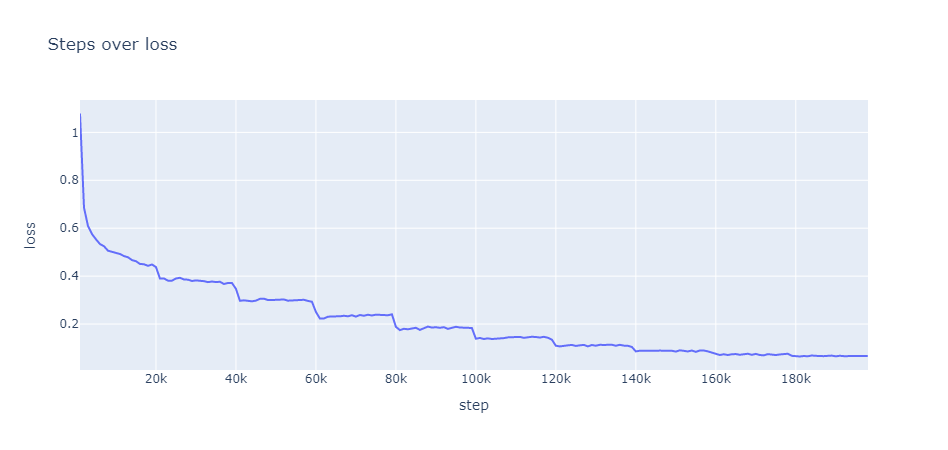

In [57]:
history.plot(x="step", y="loss", backend="plotly", title="Steps over loss")

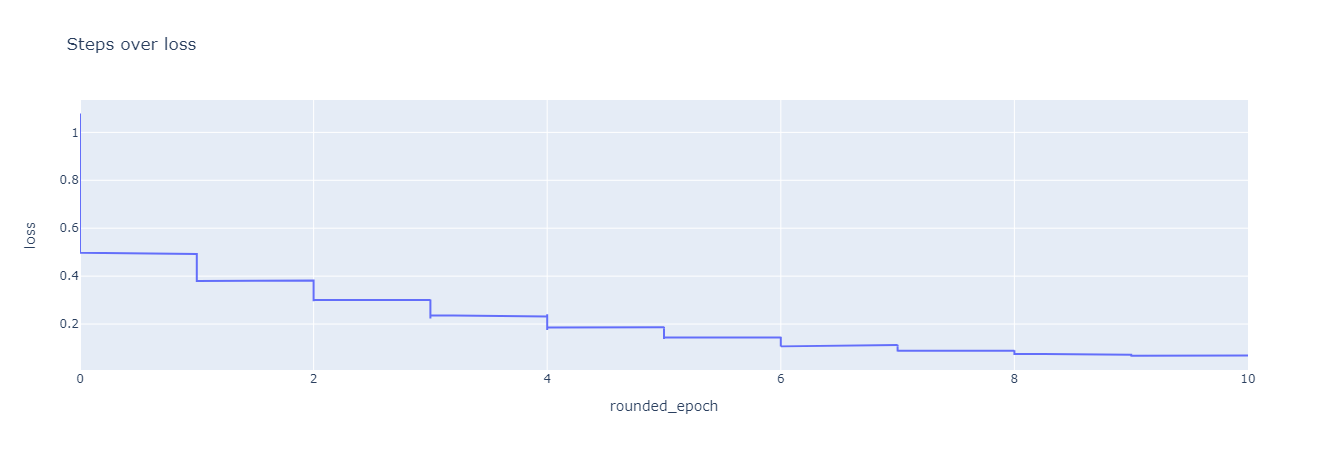

In [58]:
history["rounded_epoch"] = round(history["epoch"])
history.plot(x="rounded_epoch", y="loss", backend="plotly", title="Steps over loss")

In [ ]:
# fig = px.line(history, x="step", y="loss", title="Steps over loss")
# fig.add_trace(
#     next(px.line(history, x="step", y="").select_traces())
# )
# fig.show()


# Hyperparameter search

In [ ]:
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 7e-5, step=1e-5),
        "warmup_steps": trial.suggest_int("warmup_steps",0,total_steps*0.1,step=total_steps*0.1*0.5),
        "gradient_accumulation_steps" : trail.suggest_int("gradient_accumulation_steps" , 1 , 10)
    }

search_space = {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 7e-5, step=1e-5),
        "warmup_steps": trial.suggest_int("warmup_steps",0,total_steps*0.1,step=total_steps*0.1*0.5),
        "gradient_accumulation_steps" : trail.suggest_int("gradient_accumulation_steps" , 1 , 10)
}

def compute_objective(metrics):
    return metrics['eval_accuracy'] # or try "accuracy" if didn't work

In [ ]:
hyper_model = trainer.hyperparameter_search(direction="maximize",
                                         hp_space=hp_space,
                                         compute_objective=my_objective,
                                         n_trials=None,
                                         pruner=optuna.pruners.NopPruner(),
                                         sampler=optuna.samplers.GridSampler(search_space),
                                         )

In [75]:
#trainer.hyperparameter_search(n_trials=100)

[I 2021-09-15 20:31:54,311] A new study created in memory with name: no-name-3b5ad9cf-10eb-4575-b942-a0ce741ac9e2
Trial:
loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at C:\Users\mohnd/.cache\huggingface\transformers\fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "EGY",
    "1": "GLF",
    "2": "IRQ",
    "3": "LEV",
    "4": "NOR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "EGY": 0,
    "GLF": 1,
    "IRQ": 2,
    "LEV": 3,
    "NOR": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "be

Step,Training Loss,Validation Loss


C:\Softwarez\Anaconda\lib\site-packages\transformers\trainer.py:1312: FutureWarning:

Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.



Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
[I 2021-09-16 13:54:54,627] Trial 0 finished with value: 3.4530827368971555 and parameters: {'learning_rate': 1.380855075991113e-05, 'num_train_epochs': 3, 'seed': 37, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 3.4530827368971555.
Trial:
loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at C:\Users\mohnd/.cache\huggingface\transformers\fcf7a61cc072840ad32e1a2e8eb230a79b33d

Step,Training Loss,Validation Loss


C:\Softwarez\Anaconda\lib\site-packages\transformers\trainer.py:1312: FutureWarning:

Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.



Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32


KeyboardInterrupt: 

# Tensorboard

In [59]:
# class ModelWrapper(torch.nn.Module):
#     def __init__(self, model: torch.nn.Module):
#         super().__init__()
#         self.model = model

#     def forward(self, input_x: torch.Tensor):
#         data = self.model(input_x)

#         if isinstance(data, dict):
#             data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys())) 
#             data = data_named_tuple(**data)

#         elif isinstance(data, list):
#             data = tuple(data)

#         return data
    
# writer = SummaryWriter()
# _, tensorboard = train_test_split(validate, test_size=100, random_state=1)
# costume_data = validate_dataset.X["input_ids"][:100].cuda()